In [1]:
from PIL import Image
from PIL import ImageEnhance
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt

# Partial Occlusion

Add occlusions or noise to images to obscure or distort parts of the artwork, making it appear altered or tampered with.

In [4]:
import cv2
img = cv2.imread('C:\\AUA/Capstone Thesis\\ArtForgeryDetection\\data\\test\\a.y.-jackson_barns-1926.jpg')
style = cv2.imread("C:\AUA\Capstone Thesis\ArtForgeryDetection\data\test\adam-baltatu_still-life-with-vegetables.jpg")

#### Gaussian Noise

In [22]:
def add_gaussian_noise(image):
    noise = np.random.randint(0, 50, img.shape, dtype='uint8')
    noisy_image = cv2.add(img, noise)
    return noisy_image

gaussian_noisy_image = add_gaussian_noise(img)
cv2.imwrite('fake.jpg', gaussian_noisy_image)


True

#### Salt and Pepper Noise

In [16]:
def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy_image = np.copy(image)
    
    # Add salt noise
    num_salt = np.ceil(salt_prob * image.shape[0] * image.shape[1])  # Consider spatial dimensions only (height, width)
    coords_salt = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape[:2]]  # Ignore the color channels for coords
    noisy_image[coords_salt[0], coords_salt[1]] = 255  # Set the salt pixels to white
    
    # Add pepper noise
    num_pepper = np.ceil(pepper_prob * image.shape[0] * image.shape[1])  # Consider spatial dimensions only
    coords_pepper = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape[:2]]  # Ignore the color channels for coords
    noisy_image[coords_pepper[0], coords_pepper[1]] = 0  # Set the pepper pixels to black

    return noisy_image

# Usage
salt_pepper_noisy_image = add_salt_and_pepper_noise(img)
cv2.imwrite('fake_salt.jpg', salt_pepper_noisy_image)


True

# Style Transfer

Loading VGG19 model...
Using device: cpu
Loading image: C:\AUA/Capstone Thesis\ArtForgeryDetection\data\test\a.y.-jackson_barns-1926.jpg
Loading image: C:\AUA\Capstone Thesis\ArtForgeryDetection\data\test\adam-baltatu_still-life-with-vegetables.jpg
Extracting content and style features...
Starting optimization loop...
Step 100, Total Loss: 33039650816.0
Step 200, Total Loss: 8155171840.0
Step 300, Total Loss: 2640324608.0
Step 400, Total Loss: 1576750720.0
Step 500, Total Loss: 1173760896.0
Saving the stylized image...


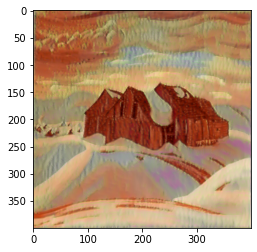

Process completed.


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load VGG19 Model
print("Loading VGG19 model...")
vgg = models.vgg19(pretrained=True).features

# Freeze all VGG parameters since we're only using it to extract features
for param in vgg.parameters():
    param.requires_grad_(False)

# Move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
print(f"Using device: {device}")

# Image loading and preprocessing
def load_image(image_path, max_size=400):
    print(f"Loading image: {image_path}")
    image = Image.open(image_path).convert('RGB')
    
    # Resize the image
    transform = transforms.Compose([
        transforms.Resize((max_size, max_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet normalization
    ])
    
    # Add batch dimension
    image = transform(image).unsqueeze(0)
    return image.to(device)

# Load content and style images
img = 'C:\\AUA/Capstone Thesis\\ArtForgeryDetection\\data\\test\\a.y.-jackson_barns-1926.jpg'
style = "C:\\AUA\\Capstone Thesis\\ArtForgeryDetection\\data\\test\\adam-baltatu_still-life-with-vegetables.jpg"
content_img = load_image(img)
style_img = load_image(style)

# Content and style layers to extract from VGG19
content_layers = ['conv_4']  # Use one layer for content
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']  # Use multiple layers for style

# Helper function to extract features
def get_features(image, model, layers):
    features = {}
    x = image
    for name, layer in enumerate(model):
        x = layer(x)
        if f'conv_{name+1}' in layers:
            features[f'conv_{name+1}'] = x
    return features

# Extract content and style features
print("Extracting content and style features...")
content_features = get_features(content_img, vgg, content_layers)
style_features = get_features(style_img, vgg, style_layers)

# Compute the Gram Matrix (used to measure style correlation)
def gram_matrix(tensor):
    _, d, h, w = tensor.size()  # batch, depth, height, width
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Style weights (relative importance of each layer)
style_weights = {'conv_1': 0.2, 'conv_2': 0.2, 'conv_3': 0.2, 'conv_4': 0.2, 'conv_5': 0.2}

# Content weight and style weight (you can adjust these to change the balance between content and style)
content_weight = 1e4
style_weight = 1e2

# Start with a copy of the content image as the "target"
target = content_img.clone().requires_grad_(True).to(device)

# Set up an optimizer
optimizer = optim.Adam([target], lr=0.003)

# Define the loss function and optimization loop
print("Starting optimization loop...")
for step in range(1, 501):  # Reduced to 500 iterations for quicker results
    target_features = get_features(target, vgg, style_layers + content_layers)
    
    # Content loss
    content_loss = torch.mean((target_features['conv_4'] - content_features['conv_4'])**2)
    
    # Style loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = gram_matrix(style_features[layer])
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss
    
    # Total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # Update the target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Print progress
    if step % 100 == 0:
        print(f"Step {step}, Total Loss: {total_loss.item()}")

# Remove normalization for saving the image
def unnormalize(tensor):
    tensor = tensor.clone().detach()
    tensor = tensor.cpu().squeeze(0)  # Remove batch dimension
    tensor = tensor * torch.tensor((0.229, 0.224, 0.225)).view(3, 1, 1) + torch.tensor((0.485, 0.456, 0.406)).view(3, 1, 1)  # Unnormalize
    tensor = tensor.clamp(0, 1)  # Clamp the values between 0 and 1
    return transforms.ToPILImage()(tensor)

# Save the stylized image
print("Saving the stylized image...")
stylized_image = unnormalize(target)
stylized_image.save('fake_stylized_image.jpg')

# Display the image
plt.imshow(stylized_image)
plt.show()

print("Process completed.")


# Image Blending

In [10]:
# Load images
back = 'C:\\AUA/Capstone Thesis\\ArtForgeryDetection\\data\\test\\a.y.-jackson_barns-1926.jpg'
fore = "C:\\AUA\\Capstone Thesis\\ArtForgeryDetection\\data\\test\\adam-baltatu_still-life-with-vegetables.jpg"
background = cv2.imread(back)
foreground = cv2.imread(fore)

# Define center and mask for seamless cloning
center = (foreground.shape[1] // 2, foreground.shape[0] // 2)
mask = 255 * np.ones(foreground.shape, foreground.dtype)

# Perform seamless cloning
blended_image = cv2.seamlessClone(foreground, background, mask, center, cv2.NORMAL_CLONE)
cv2.imwrite('blended_fake.jpg', blended_image)


True

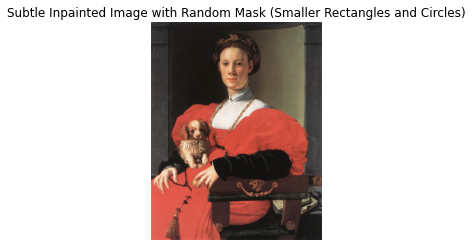

In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random

# Load the image
image_path = 'C:\\AUA\\Capstone Thesis\\ArtForgeryDetection\\data\\test\\agnolo-bronzino_portrait-of-a-lady-with-a-puppy.jpg'
image = cv2.imread(image_path)

# Define a function to generate a random mask with smaller, subtler rectangles and circles
def create_subtle_random_mask(image_shape, num_rects=3, num_circles=2):
    mask = np.zeros(image_shape[:2], np.uint8)  # Create a black mask with the same height and width as the image
    
    height, width = image_shape[:2]
    
    # Small, Random Rectangles
    for _ in range(num_rects):
        # Smaller random rectangles (width and height constrained)
        x1, y1 = random.randint(0, width - 1), random.randint(0, height - 1)
        x2, y2 = x1 + random.randint(10, 30), y1 + random.randint(10, 30)  # Smaller size
        x2, y2 = min(x2, width), min(y2, height)  # Ensure rectangle stays within image bounds
        mask[y1:y2, x1:x2] = 255  # Set the small rectangle region to 255 (degraded)
    
    # Small, Random Circles
    for _ in range(num_circles):
        radius = random.randint(5, 20)  # Smaller radius
        center_x, center_y = random.randint(radius, width - radius), random.randint(radius, height - radius)
        cv2.circle(mask, (center_x, center_y), radius, 255, -1)  # Set the small circular region to 255 (degraded)
    
    return mask

# Generate a random mask with smaller regions
random_mask = create_subtle_random_mask(image.shape, num_rects=3, num_circles=2)

# Apply inpainting using the Telea method with a small radius for subtle degradation
inpainted_image = cv2.inpaint(image, random_mask, 1, cv2.INPAINT_TELEA)

# Introduce subtle noise into the inpainted areas to make the inpainting less detectable
def add_subtle_noise_to_inpainted(image, mask):
    noisy_image = image.copy()
    noise = np.random.randint(0, 15, image.shape, dtype='uint8')  # Smaller noise range for subtle effect
    
    # Only add noise to the inpainted regions (where mask == 255)
    noisy_image[mask == 255] = cv2.add(noisy_image[mask == 255], noise[mask == 255])
    
    return noisy_image

# Apply subtle noise to make the inpainting less detectable
inpainted_noisy_image = add_subtle_noise_to_inpainted(inpainted_image, random_mask)

# Save and display the result
cv2.imwrite('subtle_inpainted_image.jpg', inpainted_noisy_image)


# Adversarial Attack

In [16]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

# Load a pre-trained ResNet-18 model
print("Loading pre-trained ResNet-18 model...")
model = resnet18(pretrained=True)
model.eval()  # Set model to evaluation mode

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load and preprocess the input image
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to the input size of ResNet
        transforms.ToTensor(),
    ])
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Function to perform FGSM attack
def fgsm_attack(image, epsilon, data_grad):
    # Collect the sign of the gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting the input image by epsilon along the gradient
    perturbed_image = image + epsilon * sign_data_grad
    # Clamp the values of the perturbed image to [0, 1] to keep it in a valid range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Image path (you can replace this with any image)
image_path = 'C:\\AUA\\Capstone Thesis\\ArtForgeryDetection\\data\\test\\adam-baltatu_still-life-with-vegetables.jpg'

# Load the image
image = load_image(image_path)

# Set the label (we'll assume the true label is random for this demo)
# You can pass the correct label if you know it
label = torch.tensor([random.randint(0, 999)]).to(device)  # Random label for demo

# Set requires_grad attribute of the input image to True for gradient computation
image.requires_grad = True

# Forward pass
output = model(image)

# Calculate the loss
loss = loss_fn(output, label)

# Backward pass: compute gradients with respect to the image
model.zero_grad()
loss.backward()

# Collect the gradients of the image
data_grad = image.grad.data

# Perform FGSM attack
epsilon = 0.03  # You can adjust the epsilon value to control the perturbation
perturbed_image = fgsm_attack(image, epsilon, data_grad)

# Convert images to numpy for display
image_np = image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
perturbed_image_np = perturbed_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

save_image(perturbed_image, 'adversarial_image.jpg')


Loading pre-trained ResNet-18 model...


# Stable Diffusion

C:\Users\User\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating image-to-image for prompt: a futuristic version of this image


  0%|          | 0/37 [00:00<?, ?it/s]

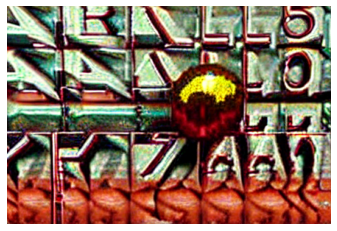

In [1]:
import torch
from PIL import Image
from diffusers import StableDiffusionImg2ImgPipeline
import matplotlib.pyplot as plt

# Check if a GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_path = 'C:\\AUA\\Capstone Thesis\\ArtForgeryDetection\\data\\test\\adam-baltatu_still-life-with-vegetables.jpg'

# Load the pre-trained image-to-image pipeline
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
img2img_pipe = img2img_pipe.to(device)

# Load an initial image (no need to resize manually)
init_image = Image.open(image_path).convert("RGB")

# Define a prompt
prompt = "a futuristic version of this image"

# Generate the image based on the initial image and prompt
print(f"Generating image-to-image for prompt: {prompt}")
image = img2img_pipe(prompt=prompt, image=init_image, strength=0.75).images[0]

# Save and display the result
image.save("img2img_generated_image.png")
plt.imshow(image)
plt.axis('off')
plt.show()


# Deforming 

In [5]:
import cv2
import numpy as np

def apply_random_warp(image_path, output_path):
    """
    Applies a random warp (affine transformation) to an image and saves the result.

    Args:
    - image_path (str): The path to the input image.
    - output_path (str): The path to save the warped image.
    """
    # Load the image
    img = cv2.imread(image_path)

    # Get the image dimensions
    rows, cols, ch = img.shape

    # Define the points for affine transformation
    pts1 = np.float32([[0, 0], [cols, 0], [0, rows]])
    pts2 = np.float32([[0, 0], [cols + 50, 50], [50, rows - 50]])

    # Get the affine transformation matrix
    M = cv2.getAffineTransform(pts1, pts2)

    # Apply the warp transformation
    warped_image = cv2.warpAffine(img, M, (cols, rows))

    # Save the warped image
    cv2.imwrite(output_path, warped_image)
    print(f"Warped image saved as: {output_path}")

# Example usage:
image_path = 'C:\\AUA\\Capstone Thesis\\ArtForgeryDetection\\data\\test\\adam-baltatu_still-life-with-vegetables.jpg'
output_path = 'fake_image_warped.jpg'
apply_random_warp(image_path, output_path)


Warped image saved as: fake_image_warped.jpg


# Changing Color Palettes

In [4]:
from PIL import Image, ImageEnhance
import cv2

def enhance_image_color(image_path, output_path, factor=1.5):
    """
    Enhances the color of an image and saves the result.

    Args:
    - image_path (str): The path to the input image.
    - output_path (str): The path to save the enhanced image.
    - factor (float): The enhancement factor for color. Default is 1.5.
    """
    # Load the image with OpenCV
    img = cv2.imread(image_path)
    
    # Convert the image from BGR (OpenCV format) to RGB (PIL format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert NumPy array to PIL Image
    pil_img = Image.fromarray(img_rgb)
    
    # Enhance the color using PIL's ImageEnhance
    enhancer = ImageEnhance.Color(pil_img)
    enhanced_img = enhancer.enhance(factor)
    
    # Save the enhanced image
    enhanced_img.save(output_path)
    print(f"Enhanced image saved as: {output_path}")

# Example usage:
image_path = 'C:\\AUA\\Capstone Thesis\\ArtForgeryDetection\\data\\test\\adam-baltatu_still-life-with-vegetables.jpg'
output_path = 'fake_image_color_adjusted.jpg'
enhance_image_color(image_path, output_path, factor=1.5)


Enhanced image saved as: fake_image_color_adjusted.jpg
